In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import requests
import os
import numpy as np

import torch
from torchvision import models
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax
from torch.optim import Adam,lr_scheduler
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset

from utils_d import *

device = torch.device("cuda:0")

import sys
sys.path.append(r'\\DESKTOP-lhj25h0\E\UCL\Dissertation\seg\pytorch_deeplab_xception')
from pytorch_deeplab_xception.modeling import deeplab

import os
os.environ['TORCH_HOME'] = r'\\DESKTOP-lhj25h0\E\ftp\data\MODELS' 

In [2]:
num_c = 2

dl = deeplab.DeepLab(num_classes=num_c,backbone = 'resnet').to(device)

for name, param in dl.named_parameters():                
    if name.startswith('backbone'):
        param.requires_grad = False

In [3]:
image_size = (400,400)

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ColorJitter(brightness = 0.15,
                                                       saturation = 0.1,
                                                       hue = 0.01,
                                                       contrast = 0.15),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [4]:
data = pd.read_csv(r'\\DESKTOP-lhj25h0\E\UCL\Dissertation\label\cropped_lb.csv')

dataset_train = Segdata(transform,image_size,
                        r'cropped_lb.csv',r'\\DESKTOP-lhj25h0\E\UCL\Dissertation\label',['cropped_input','cropped_download'])

dataset_test = Segdata(transform,image_size,
                       r'cropped_lb_test.csv',r'\\DESKTOP-lhj25h0\E\UCL\Dissertation\label',['cropped_input_test','cropped_download_test'])

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, 
                                         shuffle=True, num_workers=0,drop_last  = True)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, num_workers=0,drop_last  = False)

In [5]:
plist = [
         {'params': dl.decoder.parameters(),'lr':1e-2}
         ]

freq = get_frequency(data,image_size,2,r'\\DESKTOP-lhj25h0\E\UCL\Dissertation\label','cropped_download')

criterion = CrossEntropyLoss(weight=1/freq)

optimizer = Adam(params=plist)

scheduler = lr_scheduler.StepLR(optimizer, step_size=33,gamma=0.1)

loss_list = []

best_val_loss = float('inf')

n_epoch = 50

In [6]:
for epoch in range(n_epoch):
    training_loss,training_iou = train(dl,dataloader_train,optimizer,criterion,loss_list,num_c)
    val_loss,val_iou = evaluate(dl,dataloader_test,criterion,num_c)
    scheduler.step()
    print('finished {0}th training'.format(epoch+1))
    print('training loss: {0}, training iou: {1}'.format(training_loss.item(),training_iou))
    print('validation loss: {0}, validation iou: {1}'.format(val_loss.item(),val_iou))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(dl.state_dict(), r'\\DESKTOP-lhj25h0\E\UCL\Dissertation\seg\models\model_deeplabv3+resnet_amp_best_.pt')

finished 1th training
training loss: 1.7526046872138976, training iou: 0.24796374355500883
validation loss: 2.2254591514666875, validation iou: 0.2867390079152933
finished 2th training
training loss: 0.5730765402317047, training iou: 0.26883554580616364
validation loss: 0.5446149570246538, validation iou: 0.34306694867276655
finished 3th training
training loss: 0.36670774817466734, training iou: 0.5010587407674044
validation loss: 0.8193626450995605, validation iou: 0.4239502843316045
finished 4th training
training loss: 0.3954370319843292, training iou: 0.5116235148559952
validation loss: 0.984543198098739, validation iou: 0.3983672316118261
finished 5th training
training loss: 0.3427548885345459, training iou: 0.5567730400983748
validation loss: 0.8770303200930357, validation iou: 0.397185985041285
finished 6th training
training loss: 0.3148632347583771, training iou: 0.5741098115149523
validation loss: 0.5858125652497014, validation iou: 0.43558058826362556
finished 7th training
tra

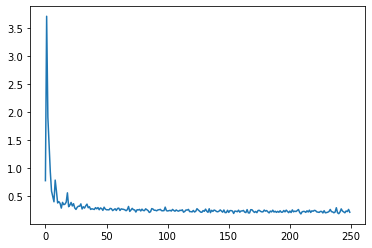

In [7]:
plt.plot(loss_list)

In [8]:
torch.save(dl.state_dict(), r'\\DESKTOP-lhj25h0\E\UCL\Dissertation\seg\models\model_deeplabv3+resnet_amp_last_.pt')